# `Laboratorio 3`
Estudiante: Roy Esteban Padilla Calderón.

Carné: B85854.


In [4]:
# Imports de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
# Lectura del archivo
df = pd.read_csv('fish_perch.csv')
target_value = 'Weight'
target_column = df[target_value]
df = df.drop(columns= [target_value])
target_column

0        5.9
1       32.0
2       40.0
3       51.5
4       70.0
5      100.0
6       78.0
7       80.0
8       85.0
9       85.0
10     110.0
11     115.0
12     125.0
13     130.0
14     120.0
15     120.0
16     130.0
17     135.0
18     110.0
19     130.0
20     150.0
21     145.0
22     150.0
23     170.0
24     225.0
25     145.0
26     188.0
27     180.0
28     197.0
29     218.0
30     300.0
31     260.0
32     265.0
33     250.0
34     250.0
35     300.0
36     320.0
37     514.0
38     556.0
39     840.0
40     685.0
41     700.0
42     700.0
43     690.0
44     900.0
45     650.0
46     820.0
47     850.0
48     900.0
49    1015.0
50     820.0
51    1100.0
52    1000.0
53    1100.0
54    1000.0
55    1000.0
Name: Weight, dtype: float64

# 1. `Función MSE(y_true, y_predict)` y `Función MAE(y_true, y_predict)` 
Recibe dos objetos pd.Series que contienen los valores reales de un conjunto de datos y los valores estimados por un modelo. 

In [6]:
def MSE(y_true: pd.Series, y_predict: pd.Series):
    return ((y_true - y_predict)**2).sum()/y_true.size

def MAE(y_true: pd.Series, y_predict: pd.Series):
    return (y_true - y_predict).sum()/y_true.size

# 2. `Función score(y_true, y_predict)` 
Recibe dos objetos pd.Series que contienen los valores reales de un conjunto de datos y los valores estimados por un modelo. Calcule y retorne el coeficiente de determinación (R2) de dicha predicción.

In [7]:
def score(y_true : pd.Series, y_predict:pd.Series):
    rss = ((y_true - y_predict)**2).sum()
    tss = ((y_true - y_true.mean())**2).sum()
    return 1-(rss/tss)

# 3. `Clase LinearRegression`

Método fit(self, x, y, max_epochs=100, threshold=0.01, learning_rate=0.001, momentum=0, decay=0, error=’mse’, regularization=’none’, lambda=0)
Encargado de ajustar los cj para obtener así el modelo.

# 4. `Método predict(self, x)` 
que recibe un objeto pandas.DataFrame x que
contiene los datos para los que se desea hacer su estimación. El método debe
retornar un objeto de tipo pd.Series con los valores estimados para cada uno de
los valores.

a. Este método será llamado después de fit, punto en el cuál ya debería
contarse con los valores de C/los pesos necesarios para hacer la estimación.


In [8]:
import sys
class LinearRegression:
    def __init__(self):
        self.c_values = None

    def predict(self, x : pd.Series):
        if not "bias" in x.columns:
            x.insert(0, "bias", np.ones(x.shape[0]))
        x_numpy = x.to_numpy()
        return pd.Series(np.matmul( x_numpy, self.c_values), x.index)

    def fit(self, x : pd.DataFrame, y : pd.Series, max_epochs=100, threshold=0.01, learning_rate=0.001, momentum=0, \
                    decay=0, error="mse", regularization="none", lambda_=0):
        
        epochs_counter = 0
        error_change = sys.maxsize
        previous_error = sys.maxsize

        if not "bias" in x.columns:
            x.insert(0, "bias", np.ones(x.shape[0]))
        
        self.c_values = np.random.rand(x.shape[1])
        
        x_numpy = x.to_numpy()
        
        finish_by_error_dif = False
        errors_list = []
        dCt = np.zeros(x.shape[1])
        
        # Mientras la época (epoch / contador de iteración) no supere el límite o el cambio en el
        # error entre una época y la anterior sea mayor a un umbral:
        while (epochs_counter<max_epochs) and not finish_by_error_dif:

            dCt_previous = dCt
            dCt = self._calculateDF(y, x_numpy, error, self.c_values, self._getRegularizationValue(lambda_, regularization))
            learning_rate = learning_rate/(1+decay)
            self.c_values = self.c_values - learning_rate * (dCt + momentum * dCt_previous)
            y_predict = np.matmul(x_numpy, self.c_values)
            error_change = MSE(y,pd.Series(y_predict, index= y.index)) if error == "mse" else MAE(y,pd.Series(y_predict, index= y.index))
            
            if epochs_counter >= 1 and (previous_error - error_change) < threshold:
                finish_by_error_dif = True
            else:
                previous_error = error_change
                errors_list.append(error_change)
            epochs_counter += 1
        
        # Gráfico para ver el comportamiento del error del modelo por las iteraciones
        len_ = len(errors_list)
        xpoints = np.linspace(0, len_, num = len_)
        plt.plot(xpoints, errors_list)
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.show()

        print('''Error:{}\nIteraciones del algoritmo:{}'''.format(error_change, epochs_counter))
        

    def _calculateDF(self, y_true : pd.Series,  x : np.array,error, c_values : np.array, regularization_value : float):
        '''Método para calcular la derivada del MSE y del MAEde las cj'''
        if error == "mse":
            return 2/y_true.size * (np.transpose(np.matmul(np.transpose(np.matmul(x,c_values) - y_true),x))) + regularization_value
        else:
            # tomado de https://stats.stackexchange.com/questions/312737/mean-absolute-error-mae-derivative
            diferences = (np.matmul(x, c_values ) > y_true)
            values = []
            for value in diferences:
                if value:
                    values.append(1)
                else:
                    values.append(-1)
            return np.array(values).mean() + regularization_value
            
    def _getRegularizationValue(self, lambda_, regularization):
        '''Método para el cálculo de la regularización para la derivada'''
        if regularization == "l1" or regularization == "lasso":
            return lambda_
        elif regularization == "l2" or regularization == "ridge":
            return 2 * lambda_ * self.c_values
        return 0
         

# 5. Utilice el set de datos proveído para probar el funcionamiento de su algoritmo. 
Recuerde que el error debe reducirse en cada iteración del algoritmo (o llegar a un “zig-zag” producto de una tasa de aprendizaje muy elevada). Luego utilice el método train_test_split de la biblioteca sklearn.model_selection para separar un conjunto de datos en un conjunto de datos de entrenamiento y otro de prueba, utilice de semilla del split el número 21 (el método permite el parámetro opcional random_state para sembrar la aleatoriedad).

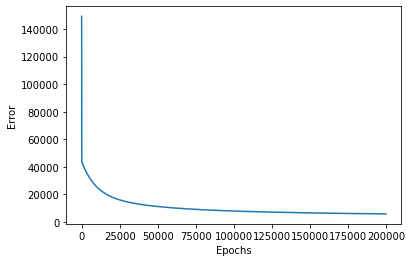

Error:5760.45932317521
Iteraciones del algoritmo:200000
R2: 0.8856894557652066


In [32]:
X_train, X_test, y_train, y_test = train_test_split(df, target_column, test_size=0.3, random_state=21)

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train,  max_epochs=200000, threshold=1e-3, learning_rate=5e-5, momentum=0.25, \
                    decay=1e-8, error="mse", regularization="l1", lambda_=0.1)

y_predict = linear_regression.predict(X_test)
print("R2:",score(y_test, y_predict))


`¿Cuál fue la combinación de parámetros que le proveyó el mejor resultado?`

La combinación de hiperparámetros que mejor resultados me proveyó fue la siguiente:

| Hiperparámetro | Valor |
|--|--|
| max_epochs | 200000 |
| threshold | 1e-3 |
| learning_rate | 5e-5 |
| momentum | 0.25 |
| decay | 1e-8 |
| error | "mse" |
| regularization | "l1" |
| lambda | 0.1 |

Generando un error de 5760.45 y un R<sup>2</sup> de 0.885 en la corrida mostrada. Como se muestra en la gráfica, el error disminuye de forma bastante acentuada en las primeras iteraciones del algoritmo o bien en las primeras épocas, para finalmente decrecer de forma más concervadora, aún así comparando con los valores iniciales, esta medida disminuyó bastante en las 200 000 épocas hasta lograr un R<sup>2</sup> bastante alto lo cual indica que la estimación ha sido bastante certera.

`Prueba con varias semillas`


Semilla: 84


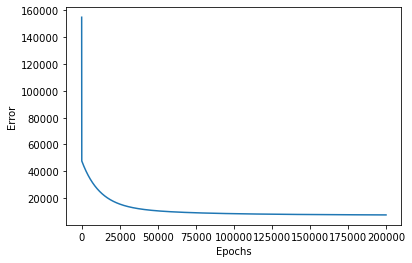

Error:7403.246009810418
Iteraciones del algoritmo:200000
R2: 0.8492561716316956

Semilla: 87


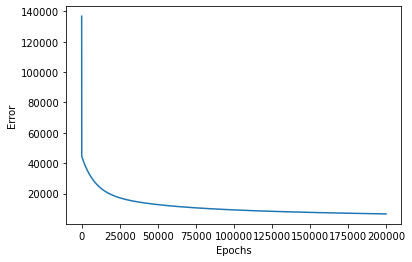

Error:6590.260273381001
Iteraciones del algoritmo:200000
R2: 0.9217815468821146

Semilla: 80


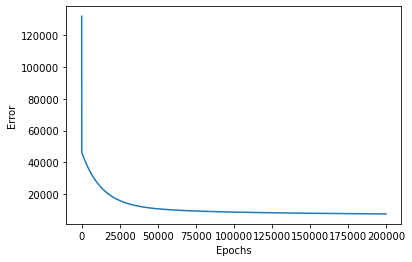

Error:7465.961102078384
Iteraciones del algoritmo:200000
R2: 0.8992066118173437

Semilla: 22


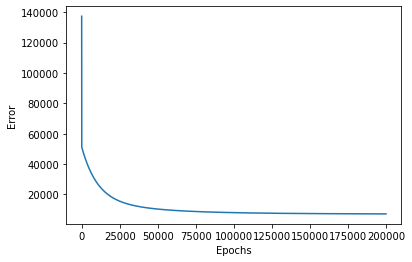

Error:7205.327235019598
Iteraciones del algoritmo:200000
R2: 0.852598034365227

Semilla: 95


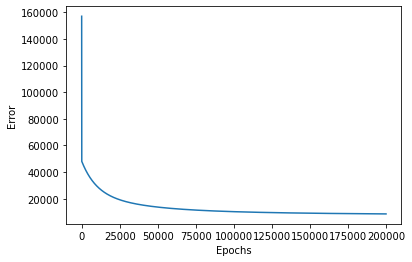

Error:8576.309084360255
Iteraciones del algoritmo:200000
R2: 0.8966255479404308

Semilla: 83


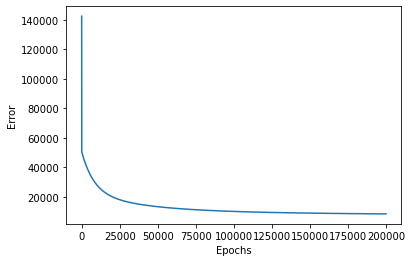

Error:8417.320427383234
Iteraciones del algoritmo:200000
R2: 0.9306164223436749

Semilla: 3


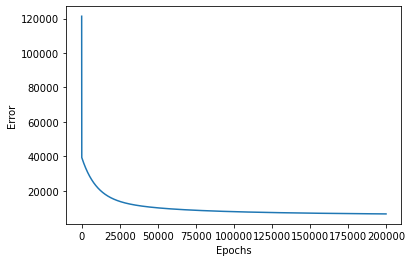

Error:6543.133020468452
Iteraciones del algoritmo:200000
R2: 0.9104862013946123

Semilla: 51


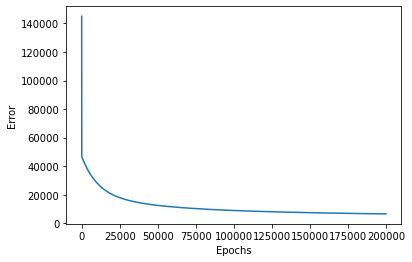

Error:6584.711562928455
Iteraciones del algoritmo:200000
R2: 0.9178923708338464

Semilla: 6


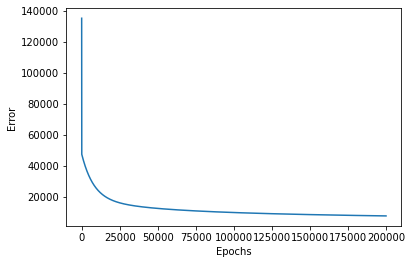

Error:7496.506759511428
Iteraciones del algoritmo:200000
R2: 0.9264556248168536

Semilla: 98


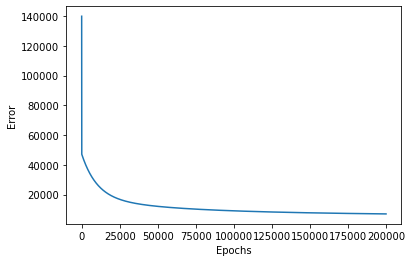

Error:6953.229419581592
Iteraciones del algoritmo:200000
R2: 0.9085485259136283


In [11]:
seeds = np.random.randint(0,100,10)

for seed in seeds:
  print('\nSemilla:',seed)
  X_train, X_test, y_train, y_test = train_test_split(df, target_column, test_size=0.3, random_state=seed)
  linear_regression = LinearRegression()
  linear_regression.fit(X_train, y_train,  max_epochs=200000, threshold=1e-3, learning_rate=5e-5, momentum=0.25, \
                    decay=1e-8, error="mse", regularization="l1", lambda_=0.1)

  y_predict = linear_regression.predict(X_test)
  print('R2:',score(y_test, y_predict))
  

`¿Qué pasa si utiliza esa misma combinación pero cambia la semilla del
train_test_split?`

`Si pasa algo inusual: ¿Por qué cree que pasa esto?`

Como se observa en los gráficos y resultados del R<sup>2</sup>, realmente se obtuvieron muy buenos resultados los cuales se mantienen cercanos a cuando se utilizó la semilla en 21, incluso la mayoría superándo el valor de este último, obteniendo así resultados que van desde el 84% de R<sup>2</sup> el más bajo hasta un 93% de R<sup>2</sup> el más alto. Aún así se puede observar que los valores de error en todos los casos son altos lo cual indica que los resultados no van a ser del todo precisos, sin embargo, como lo muestran los gráficos del comportamiento del error, se nota que este se redujo en bastante medida conforme el algoritmo itera recalculando los pesos del vector C hasta que llega un punto en el que la caída de este disminuye de forma lenta.